# BOLL线和成交量相关问题
1. 计算BOLL线打开和成交量的关系以及成功率
2. 选择不同的BOLL宽带以及成交量放大阈值是不是影响成功率
3. 大盘怎样影响成功率的，例如：大盘macd,大盘成交量,大盘boll形态,大盘均线
4. 个股怎么最优选择BOLL宽带阈值于成交量放大阈值
5. 通过每天前15分钟的成交量预测全天成交量准确度如何
6. 通道经历过大盘的上涨或者下跌对结果有什么影响
7. 通道打开时成交量未发生明显增加，股价大幅度上升或下降
8. 通道内成交量的最大值于最小值于通道打开点成交量关系
9. 通道打开使用bollwidth斜率作为打开依据还是使用bollwidth阈值作为依据

In [1]:
import stock
import kline
import xueqiu
import numpy as np

In [2]:
def searchBoll(k):
    bo = stock.bollLineK(k,20)
    bw = stock.bollWidth(bo)
    bww = bw<0.2
    
def K(code):
    c,k,d = stock.loadKline(code)
    bo = stock.bollLineK(k,20)
    bw = stock.bollWidth(bo)
    kline.Plote(code,'d',config={
    'macd':False,
    'figure':[
        [{
        'data':bw,
        'color':'red'
        }]
    ]}).show()    

先找出通道，然后标记并进行观察分析找出一个大概的规律。然后使用程序在做深入分析

# 设三个参数一个是最大值上限阈值，一个是通道宽带上限阈值，以及一个长度下限阈值

In [3]:
#满足bw<ut , 长度大于nt的部分
def bollWidthUPSelect(bw,ut,nt):
    n = 0
    bi = -1
    a = []
    for i in range(len(bw)):
        if bw[i] < ut:
            if n==0:
                bi = i
            n+=1
        elif bi != -1 and n>nt:
            a.append((bi,i))
            bi = -1
            n = 0
        else:
            bi = -1
            n = 0
    if bi!= -1 and n>=nt:
        a.append((bi,len(bw)))
    return a
#返回头部满足宽带小于wt,长度大于等于nt的位置
def bollWidthHead(bw,bi,ei,wt,nt):
    for i in range(bi,ei-nt):
        head = bw[i:i+nt]
        r = head.max()-head.min()
        if head.max()-head.min()<wt:
            return i+nt
    return -1
#更加这些阈值返回一个范围列表，以及一些特殊点
def bollWidthSelect(k,ut=0.2,wt=0.1,nt=15):
    bo = stock.bollLineK(k,20)
    bw = stock.bollWidth(bo)
    r = []
    a = bollWidthUPSelect(bw,ut,nt)
    #只要前面出现一段宽度变化幅度小于wt，并且长度>=nt的起始段，后面的都算返回区域
    for b in a:
        off = bollWidthHead(bw,b[0],b[1],wt,nt)
        if off < b[1] and off>=(b[0]+nt):
            r.append((off,b[1]))
    return r,bo,bw
#成交量大于平均值1.5倍
def volumeSelect(k,r,vt=1.5):
    vma = stock.ma(k[:,0],20)
    a = []
    for b in r:
        a.append(np.argwhere(k[b[0]:b[1],0]/vma[b[0]:b[1]]>vt)+b[0])
    return np.vstack(a).reshape(-1)
#要求股价买入点股价正在20日均线上面
def ma20Select(k,a):
    r = []
    bo = stock.bollLineK(k,20)
    for i in a:
        if k[i,4]>bo[i,1]:
            r.append(i)
        
    return np.array(r)

#使用macd将买入点分为主买入点靠近金叉，主买入点离开金叉1/3最大MACD正周期变为次买入点，和次买入点远离金叉
def macdSelect(k,a):
    macd,_ = stock.macd(k)
    p = macd[0]
    bi = 0
    r = []
    maxt = 0
    for i in range(len(macd)):
        m = macd[i]
        if m>0 and p<0:
            bi = i  
        elif m<0 and p>0:
            r.append([bi,i])
            if i-bi>maxt:
                maxt = i-bi
            bi = 0
        p = m
    if bi !=0:
        r.append([bi,len(k)])
        if i-bi>maxt:
            maxt = i-bi        
    main = []
    second = []
    offset = 0
    for b in r:
        first = True
        for i in range(offset,len(a)):
            if b[0]<=a[i] and a[i]<b[1]:
                if first:
                    if a[i]<b[0]+maxt/3:
                        main.append(a[i])
                    else:
                        second.append(a[i])
                else:
                    second.append(a[i])
                first  = False
            elif first==False:
                offset = i
                break
    return main,second

In [4]:
#红色粗线更加靠近macd金叉
def ShowBollSelect(code,code2=None):
    c,k,d = stock.loadKline(code)
    r,bo,bw = bollWidthSelect(k,0.20,0.2,15)
    sel = np.zeros((len(k)))
    mains,seconds = macdSelect(k,ma20Select(k,volumeSelect(k,r,1.5)))
    for b in r:
        sel[b[0]:b[1]] = 0.2
    kline.Plote(code,'d',config={
    'macd':False,
    'vlines':[
        {
            "color":"red",
            "linewidth":2,
            "linestyle":"-.",
            "x":mains
        },
        {
            "color":"green",
            "linewidth":1,
            "linestyle":"--",
            "x":seconds
        }        
    ],
    'figure':[
        [{
        'data':bw,
        'color':'red'
        },{
        'data':sel,
        'color':'blue'
        }]
    ]}).show(code2=code2) 

In [5]:
ShowBollSelect('SH:600460')

Box(children=(Button(description='上一页', style=ButtonStyle()), Button(description='下一页', style=ButtonStyle()), …

Output()

In [6]:
ShowBollSelect('SH:600222')

Box(children=(Button(description='上一页', style=ButtonStyle()), Button(description='下一页', style=ButtonStyle()), …

Output()

# 使用主买入点进20均线卖出

In [7]:
import matplotlib.pyplot as plt

In [8]:
def calcMa20Rate(c,k,d,UT=0.2,WT=0.2,LT=15,VT=1.5):
    r,bo,bw = bollWidthSelect(k,UT,WT,LT)
    sel = np.zeros((len(k)))
    mains,seconds = macdSelect(k,ma20Select(k,volumeSelect(k,r,VT)))
    ma20 = stock.maK(k,20)
    r = 1
    n = 0
    s = 0
    ra = []
    for i in mains:
        buy = k[i,4]
        for j in range(i,len(k)):
            if k[j,4]<ma20[j]:
                r *= k[j,4]/buy
                s += k[j,4]/buy
                ra.append(k[j,4]/buy)
                n += 1
                buy = 0
                break
    if buy > 0:
        r *= k[-1,4]/buy
        s += k[j,4]/buy
        ra.append(k[j,4]/buy)
        n += 1
    return r,n,s,np.array(ra)

def calcBaseline(k,m,bi,ei):
    r = 1.
    prev = m[bi]
    buy = -1
    tr = []
    s = 0
    ra = []
    for i in range(bi+1,ei):
        macD = m[i]
        if macD*prev<0:
            close = k[i,4]
            if macD>0:
                buy = close
                buyi = i
            elif buy>0:
                tr.append([buyi,i,buy,close])
                r *= close/buy
                s += close/buy
                ra.append(close/buy)
                buy = -1
        prev = macD
    return r,len(tr),s,np.array(ra)

def calcMacdRate(c,k,d):
    macd,_ = stock.macd(k)
    return calcBaseline(k,macd,0,len(k))

def compareMacdAndBollMa20Plot(code,UT=0.2,WT=0.2,LT=15,VT=2):
    c,k,d = stock.loadKline(code)
    r,n,s,ra = calcMacdRate(c,k,d)
    print('MACD',s/n,(ra>1).sum()/n)
    r1,n1,s1,ra1 = calcMa20Rate(c,k,d,UT,WT,LT,VT)
    print('BOLLMA20',s1/n1,(ra1>1).sum()/n1)
    gs_kw = dict(width_ratios=[n,n1], height_ratios=[1])
    fig, axs = plt.subplots(1, 2,figsize=(28,12),sharey=True,gridspec_kw = gs_kw)
    fig.subplots_adjust(wspace=0.01)
    axs[0].set_title('%s %s'%(c[2],c[1]))
    axs[0].plot(np.arange(n),ra)
    axs[0].axhline(ra[ra>1].mean(),color='yellow')
    axs[0].axhline(s/n,color='red')
    axs[0].axhline(ra[ra<1].mean(),color='green')
    axs[0].axhline(1,color='black')
    axs[1].plot(np.arange(n1),ra1)
    axs[1].axhline(ra1[ra1>1].mean(),color='yellow')
    axs[1].axhline(s1/n1,color='red')
    axs[1].axhline(ra1[ra1<1].mean(),color='green')
    axs[1].axhline(1,color='black')

MACD 1.0332553352608713 0.4014084507042254
BOLLMA20 1.107694005085707 0.4230769230769231


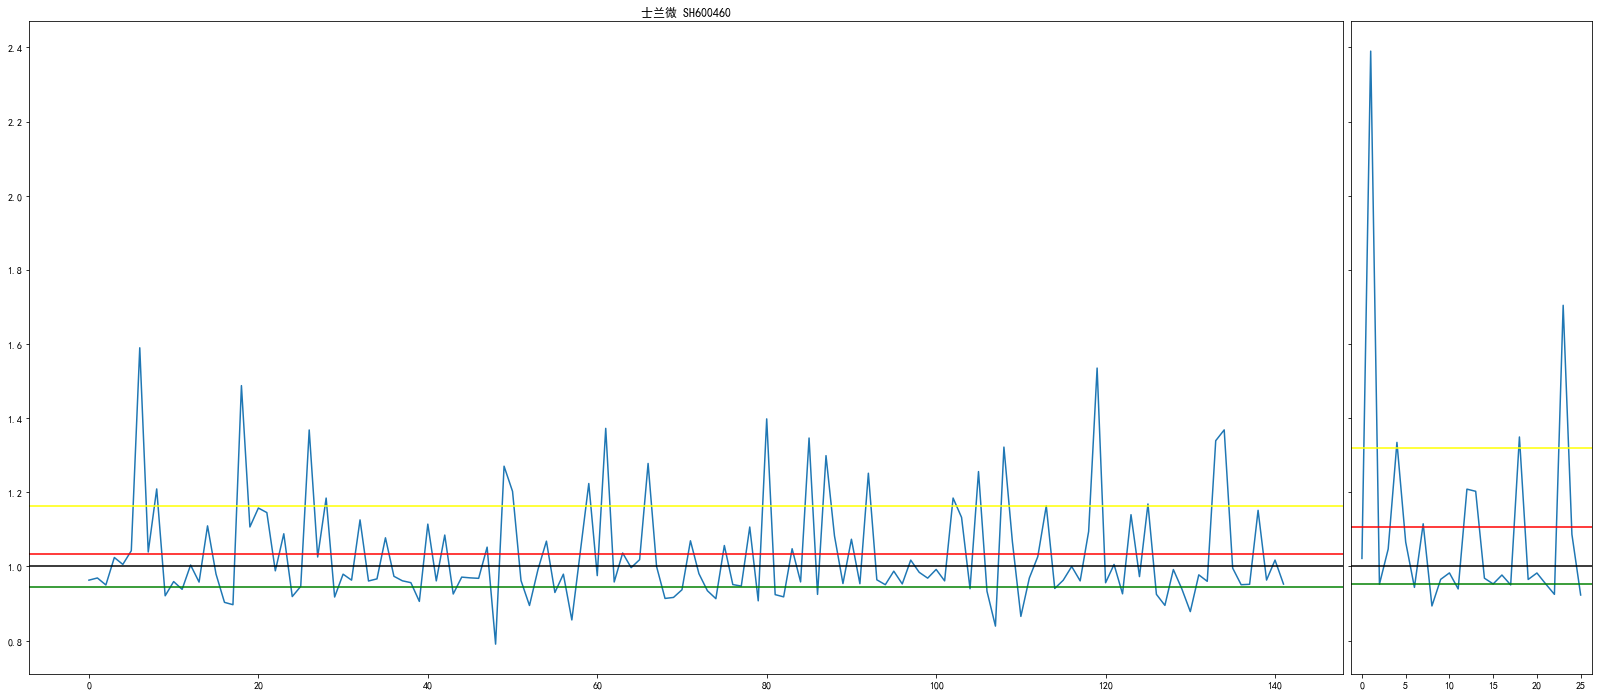

In [9]:
compareMacdAndBollMa20Plot('SH:600460')

MACD 1.0069737802501946 0.3465909090909091
BOLLMA20 1.0119671707334106 0.27586206896551724


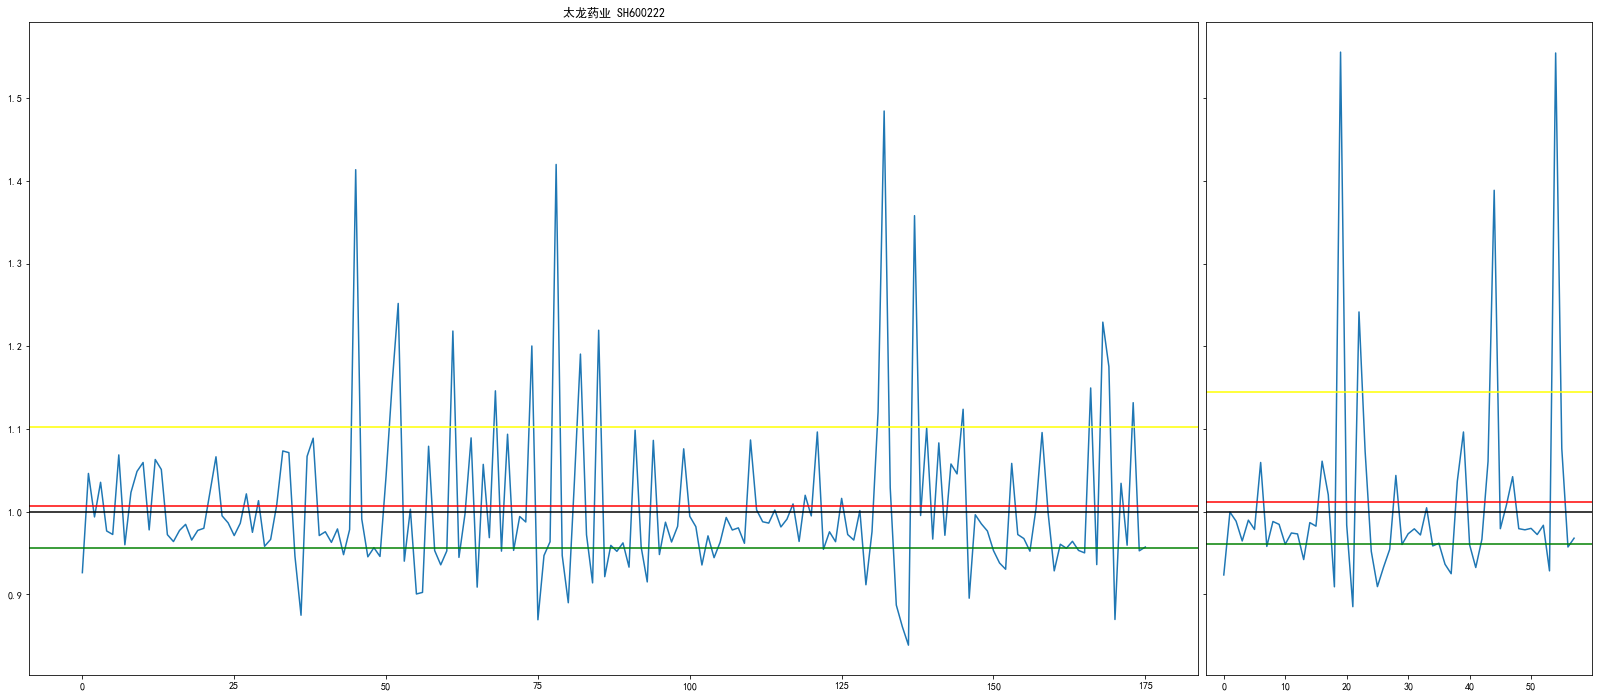

In [10]:
compareMacdAndBollMa20Plot('SH:600222',LT=15)